In [1]:
import os
import re
import warnings

warnings.filterwarnings("ignore")

import altair as alt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pysentiment2 as ps
import seaborn as sns
import spacy
from dotenv import find_dotenv, load_dotenv
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from rich import print
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline

from sentibignomics import senti_bignomics

%load_ext rich


load_dotenv(find_dotenv())


True

In [2]:
nltk.download("stopwords")
nltk.download("vader_lexicon")
nltk.download('punkt')
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing

### Load documents


In [3]:
documents_list = os.listdir("./extracted/")

docs = {
    doc.split("_")[0]: open(f"./extracted/{doc}", "r").read()
    for doc in documents_list
    if doc.endswith(".txt")
}

### Preprocess documents


In [4]:
# looking at one example document
print(docs["AAPL"])

Item 7. Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations 

The following discussion should be read in conjunction with the consolidated financial statements and accompanying 
notes included in Part II, Item 8 of this Form 10-K. This section of this Form 10-K generally discusses 2020 and 
2019 items and year-to-year comparisons between 2020 and 2019. Discussions of 2018 items and year-to-year 
comparisons between 2019 and 2018 that are not included in this Form 10-K can be found in &#8220;Management&#8217;s
Discussion and Analysis of Financial Condition and Results of Operations&#8221; in Part II, Item 7 of the 
Company&#8217;s Annual Report on Form 10-K for the fiscal year ended September 28, 2019. 

Fiscal Year Highlights 

COVID-19 Update 

COVID-19 has spread rapidly throughout the world, prompting governments and businesses to take unprecedented 
measures in response. Such measures have included restrictions on travel and business operations, temporary 
closures of businesses, and quarantines and shelter-in-place orders. The COVID-19 pandemic has significantly 
curtailed global economic activity and caused significant volatility and disruption in global financial markets. 
The COVID-19 pandemic and the measures taken by many countries in response have adversely affected and could in the
future materially adversely impact the Company&#8217;s business, results of operations, financial condition and 
stock price. 

During 2020, aspects of the Company&#8217;s business were adversely affected by the COVID-19 pandemic, with many of
the Company&#8217;s retail stores, as well as channel partner points of sale, temporarily closed at various times, 
and the vast majority of the Company&#8217;s employees working remotely. The Company has reopened some of its 
offices and the majority of its retail stores, subject to operating restrictions to protect public health and the 
health and safety of employees and customers, and it continues to work on safely re-opening the remainder of its 
offices and retail stores, subject to local rules and regulations. 

The full extent of the future impact of the COVID-19 pandemic on the Company&#8217;s operational and financial 
performance is currently uncertain and will depend on many factors outside the Company&#8217;s control, including, 
without limitation, the timing, extent, trajectory and duration of the pandemic, the development and availability 
of effective treatments and vaccines, the imposition of protective public safety measures, and the impact of the 
pandemic on the global economy and demand for consumer products. Refer to Part I, Item 1A of this Form 10-K under 
the heading &#8220;Risk Factors,&#8221; for more information. 

The Company believes its existing balances of cash, cash equivalents and marketable securities, along with 
commercial paper and other short-term liquidity arrangements, will be sufficient to satisfy its working capital 
needs, capital asset purchases, dividends, share repurchases, debt repayments and other liquidity requirements 
associated with its existing operations. 

Fiscal 2020 Highlights 

Total net sales increased 6% or $14.3 billion during 2020 compared to 2019, primarily driven by higher net sales of
Services and Wearables, Home and Accessories. The weakness in foreign currencies had an unfavorable impact on net 
sales during 2020. 

In April 2020, the Company announced an increase to its current share repurchase program authorization from $175 
billion to $225 billion and raised its quarterly dividend from $0.1925 to $0.205 per share beginning in May 2020. 
During 2020, the Company repurchased $72.5 billion of its common stock and paid dividends and dividend equivalents 
of $14.1 billion. 

On August 28, 2020, the Company effected a four-for-one stock split to shareholders of record as of August 24, 
2020. All share, RSU and per share or per RSU information has been retroactively adjusted to reflect the stock

In [5]:
# getting documents that have less than 1000 characters
doc_lengths = {k: len(v) for k, v in docs.items()}
print([(k, v) for k, v in doc_lengths.items() if v < 1000])
docs_to_remove = [k for k, v in doc_lengths.items() if v < 1000]


[
    ('CVX', 293),
    ('C', 0),
    ('DE', 251),
    ('ETN', 269),
    ('GE', 106),
    ('IBM', 238),
    ('JPM', 431),
    ('MA', 0),
    ('PGR', 250),
    ('WFC', 324),
    ('XOM', 288)
]

The above tickers do not have relevant content in their MD&A, possibly due to cross-reference to other sections or unavailability of the documents. We drop these tickers from the list.


In [6]:
for key in docs_to_remove:
    docs.pop(key, None)

### Preprocessing Text

In [7]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(["table_end", "table_start"])


class Tokenizer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))
        self.stop_words.update(["table_end", "table_start"])

    def tokenize(self, text):
        # Clean text
        text = text.lower()  # Lowercase
        text = re.sub(
            r"\$\d+(\.\d+)?(m| million| billion)?", " ", text
        )  # Remove dollar amounts
        text = re.sub(r"\d+(\.\d+)?%", " ", text)  # Remove percentages
        text = re.sub(r"\b\d+(\.\d+)?\b", " ", text)  # Remove standalone numbers
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation

        # Tokenize and remove stopwords
        tokens = [
            word for word in nltk.word_tokenize(text) if word not in self.stop_words
        ]

        # Lemmatize
        lemmatized = [self.lemmatizer.lemmatize(token) for token in tokens]

        return lemmatized

We define the preprocessing pipeline as follows:
- Convert to lowercase
- Remove mention of dollar amounts
- Remove percentages
- Remove standalone numbers
- Remove extra whitespaces and punctuations
- Tokenize by word and remove stopwords
- Lemmatize words using WordNetLemmatizer

Since the focus is on a qualitative analysis of the MD&A, we remove dollar amounts, percenages and numbers as they are not relevant for the analysis. We also remove stopwords and lemmatize the words to reduce the dimensionality of the data and to focus on the content of the documents.

In [8]:
tokenizer = Tokenizer()


def preprocess_text(text):
    return " ".join(tokenizer.tokenize(text))


### TF-IDF


In [9]:
tf_idf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2000,
    preprocessor=preprocess_text,
    strip_accents="unicode",
)

tf_idf = tf_idf_vectorizer.fit_transform(docs.values())

In [10]:
# Create a DataFrame to display the TF-IDF values
tf_idf_df = pd.DataFrame(
    tf_idf.todense(),
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=docs.keys(),
)

# Add a row for the document frequency
tf_idf_df.loc["0_DOC_FREQ"] = (tf_idf_df > 0).sum()
tf_idf_df.sort_index().round(2)

,1a,3d,5g,aa,ability,able,absence,absolute,aca,accelerate,...,writeoff,written,yearend,yearoveryear,yeartoyear,yen,yet,yield,york,zero
0_DOC_FREQ,59.00,8.00,7.00,17.00,83.00,54.00,25.00,15.0,6.0,30.0,...,11.00,33.00,18.00,42.00,19.00,21.00,44.00,45.00,16.0,19.00
AAPL,0.03,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,...,0.00,0.00,0.00,0.05,0.05,0.02,0.02,0.00,0.0,0.00
ABBV,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.0,0.01
ABT,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.01
ACN,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0.0,...,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.03,0.0,0.00
V,0.01,0.00,0.00,0.01,0.00,0.01,0.02,0.0,0.0,0.0,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.0,0.00
VRTX,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.0,0.0,0.0,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
VZ,0.00,0.00,0.11,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00


#### Top 50 most frequent words

In [11]:
print(tf_idf_df.T.sort_values("0_DOC_FREQ", ascending=False).head(50).index)
tf_idf_df.drop("0_DOC_FREQ", inplace=True)

Index(['contract', 'exchange', 'investing', 'determine', 'prior', 'driven',
       'ended', 'development', 'charge', 'circumstance', 'strategy', 'return',
       'order', 'expect', 'one', 'uncertainty', 'fair', 'regarding', 'measure',
       'corporate', 'historical', 'december', 'ability', 'likely', 'differ',
       'expenditure', 'annual', 'see', 'technology', 'end', 'demand',
       'however', 'working', 'margin', 'equity', 'event', 'risk', 'using',
       'source', 'carrying', 'experience', 'resulting', 'require', 'currently',
       'administrative', 'applicable', 'assessment', 'continued', 'authority',
       'settlement'],
      dtype='object')

In [12]:
# Get the top 10 terms by TF-IDF value for each document
top_tfidf = (
    (
        tf_idf_df.stack()
        .reset_index()
        .rename(
            columns={
                0: "tfidf",
                "level_0": "document",
                "level_1": "term",
                "level_2": "term",
            }
        )
    )
    .sort_values(by=["document", "tfidf"], ascending=[True, False])
    .groupby(["document"])
    .head(10)
)

top_tfidf

,document,term,tfidf
118,AAPL,apple,0.375355
15,AAPL,accessory,0.301989
1652,AAPL,september,0.207151
1082,AAPL,marketable,0.164501
806,AAPL,gross,0.154029
...,...,...,...
174979,WMT,january,0.140389
175639,WMT,segment,0.118282
174167,WMT,average,0.107986
174767,WMT,free,0.105298


In [13]:
# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand["tfidf"] = (
    top_tfidf_plusRand["tfidf"] + np.random.rand(top_tfidf.shape[0]) * 0.0001
)

# Create a base chart
base = (
    alt.Chart(top_tfidf_plusRand)
    .encode(x="rank:O", y="document:N")
    .transform_window(
        rank="rank()",
        sort=[alt.SortField("tfidf", order="descending")],
        groupby=["document"],
    )
)

# Create a heatmap of the top 10 terms by TF-IDF value for each document
heatmap = base.mark_rect().encode(color="tfidf:Q")
# Add text labels for the terms
text = base.mark_text(baseline="middle").encode(
    text="term:N",
    color=alt.condition(
        alt.datum.tfidf >= 0.23, alt.value("white"), alt.value("black")
    ),
)

(heatmap + text).properties(width=1000)

alt.LayerChart(...)

The above shows the top 10 words with the highest TF-IDF scores for each document. We can see that the words are relevant to the content and industry of each stock ticker. For example, Boeing Airlines (BA) has words like "aircraft", "airline", "contract", while Tesla (TSLA) has words like "automotive", "energy", "vehicle".

This indicates that the TF-IDF scores are capturing the relevant content of the documents.

## Sentiment analysis


To perform sentiment analysis using the lexicons, we tokenize each document into sentences, apply the preprocessing pipeline, and then calculate the sentiment scores for each sentence using the lexicons.

### Using VADER Dictionary (Generic)

In [14]:
VADER_res = []
vader = SentimentIntensityAnalyzer()


for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = vader.polarity_scores(preprocess_text(sent))

        VADER_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "VADER_Negative": scores["neg"],
                "VADER_Neutral": scores["neu"],
                "VADER_Positive": scores["pos"],
                "VADER_Compound": scores["compound"],
            }
        )

print("Processed using VADER")
VADER_res = pd.DataFrame(VADER_res)

Processed using VADER

### Using Financial Dictionaries

#### Loughran and McDonald Financial Sentiment Dictionaries

Loughran, Tim and McDonald, Bill, When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks (March 4, 2010). Journal of Finance, Forthcoming, Available at SSRN: https://ssrn.com/abstract=1331573

In [15]:
lm = ps.LM(tokenizer=tokenizer)

LM_res = []

for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = lm.get_score(lm.tokenize(sent))
        LM_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "LM_Positive": scores["Positive"],
                "LM_Negative": scores["Negative"],
                "LM_Polarity": scores["Polarity"],
                "LM_Subjectivity": scores["Subjectivity"],
            }
        )


print("Processed using LM financial dictionary")
LM_res = pd.DataFrame(LM_res)


Processed using LM financial dictionary

#### SentiBigNomics (VADER-based)

Consoli, S., Barbaglia, L., & Manzan, S. (2022). Fine-grained, aspect-based sentiment analysis on economic and financial lexicon. Knowledge-Based Systems, 247, 108781. https://doi.org/10.1016/j.knosys.2022.108781

In [16]:
SBN_res = []
sbn_vader = SentimentIntensityAnalyzer()
sbn_vader.lexicon.update(senti_bignomics)

for k, v in docs.items():
    for sent in nltk.sent_tokenize(v):
        scores = sbn_vader.polarity_scores(preprocess_text(sent))

        SBN_res.append(
            {
                "Document": k,
                "Sentence": sent,
                "SBN_Negative": scores["neg"],
                "SBN_Neutral": scores["neu"],
                "SBN_Positive": scores["pos"],
                "SBN_Compound": scores["compound"],
            }
        )

print("Processed using SentiBigNomics")

SBN_res = pd.DataFrame(SBN_res)


Processed using SentiBigNomics

### Using pre-trained model from HuggingFace

[FinBERT](https://huggingface.co/ProsusAI/finbert): Araci, D. (2019). FinBERT: Financial Sentiment Analysis with Pre-trained Language Models. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1908.10063


In [17]:
pipe = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0)

In [18]:
finbert_results = []

for ticker, doc in docs.items():
    for sent in nltk.sent_tokenize(doc):
        sentiment = pipe(
            sent, padding=True, truncation=True, max_length=512, top_k=None
        )

        finbert_results.append(
            {"Ticker": ticker, "Sentence": sent, "Sentiment": sentiment}
        )

    print(f"Processed {ticker} using FinBERT")

print("Processed using FinBERT")

Processed AAPL using FinBERT

Processed ABBV using FinBERT

Processed ABT using FinBERT

Processed ACN using FinBERT

Processed ADBE using FinBERT

Processed ADI using FinBERT

Processed ADP using FinBERT

Processed AMAT using FinBERT

Processed AMD using FinBERT

Processed AMGN using FinBERT

Processed AMZN using FinBERT

Processed AVGO using FinBERT

Processed AXP using FinBERT

Processed BAC using FinBERT

Processed BA using FinBERT

Processed BKNG using FinBERT

Processed BLK using FinBERT

Processed BMY using FinBERT

Processed BRK-B using FinBERT

Processed BSX using FinBERT

Processed BX using FinBERT

Processed CAT using FinBERT

Processed CB using FinBERT

Processed CI using FinBERT

Processed CMCSA using FinBERT

Processed COP using FinBERT

Processed COST using FinBERT

Processed CRM using FinBERT

Processed CSCO using FinBERT

Processed CVS using FinBERT

Processed DHR using FinBERT

Processed DIS using FinBERT

Processed ELV using FinBERT

Processed GILD using FinBERT

Processed GOOGL using FinBERT

Processed GS using FinBERT

Processed HD using FinBERT

Processed HON using FinBERT

Processed INTC using FinBERT

Processed INTU using FinBERT

Processed ISRG using FinBERT

Processed KO using FinBERT

Processed LIN using FinBERT

Processed LLY using FinBERT

Processed LMT using FinBERT

Processed LOW using FinBERT

Processed LRCX using FinBERT

Processed MCD using FinBERT

Processed MDLZ using FinBERT

Processed MDT using FinBERT

Processed META using FinBERT

Processed MMC using FinBERT

Processed MRK using FinBERT

Processed MSFT using FinBERT

Processed MS using FinBERT

Processed MU using FinBERT

Processed NEE using FinBERT

Processed NFLX using FinBERT

Processed NKE using FinBERT

Processed NOW using FinBERT

Processed NVDA using FinBERT

Processed ORCL using FinBERT

Processed PANW using FinBERT

Processed PEP using FinBERT

Processed PFE using FinBERT

Processed PG using FinBERT

Processed PLD using FinBERT

Processed PM using FinBERT

Processed QCOM using FinBERT

Processed REGN using FinBERT

Processed RTX using FinBERT

Processed SBUX using FinBERT

Processed SCHW using FinBERT

Processed SPGI using FinBERT

Processed SYK using FinBERT

Processed TJX using FinBERT

Processed TMO using FinBERT

Processed TSLA using FinBERT

Processed TXN using FinBERT

Processed T using FinBERT

Processed UBER using FinBERT

Processed UNH using FinBERT

Processed UNP using FinBERT

Processed UPS using FinBERT

Processed VRTX using FinBERT

Processed VZ using FinBERT

Processed V using FinBERT

Processed WMT using FinBERT

Processed using FinBERT

In [19]:
finbert_results_df = pd.json_normalize(
    finbert_results, record_path="Sentiment", meta=["Ticker", "Sentence"]
).pivot_table(
    values="score",
    index=["Ticker", "Sentence"],
    columns="label",
)

finbert_results_df

label                                                      negative   neutral  \
Ticker Sentence                                                                 
AAPL    Item 7.                                            0.059011  0.917935   
       (2) Wearables, Home and Accessories net sales i...  0.011777  0.933356   
       (3) Services net sales include sales from the C...  0.011173  0.942424   
       2016-13, Financial Instruments &#8211; Credit L...  0.064615  0.907286   
       Actual results may differ from these estimates,...  0.717033  0.246972   
...                                                             ...       ...   
WMT    When facts and circumstances change, we reasses...  0.029786  0.944516   
       When necessary, we record a LIFO provision for ...  0.027338  0.940747   
       While ROI is considered a non-GAAP financial me...  0.007277  0.217625   
       While fiscal 2019 included a pre-tax loss of $4...  0.054686  0.929661   
       While we are awaiting anticipated technical gui...  0.400724  0.566378   

label                                                      positive  
Ticker Sentence                                                      
AAPL    Item 7.                                            0.023054  
       (2) Wearables, Home and Accessories net sales i...  0.054867  
       (3) Services net sales include sales from the C...  0.046403  
       2016-13, Financial Instruments &#8211; Credit L...  0.028099  
       Actual results may differ from these estimates,...  0.035995  
...                                                             ...  
WMT    When facts and circumstances change, we reasses...  0.025698  
       When necessary, we record a LIFO provision for ...  0.031915  
       While ROI is considered a non-GAAP financial me...  0.775098  
       While fiscal 2019 included a pre-tax loss of $4...  0.015653  
       While we are awaiting anticipated technical gui...  0.032898  

[40156 rows x 3 columns]

In [20]:
finbert_results_df.groupby("Ticker")[['negative', 'neutral', 'positive']].agg("mean")

label,negative,neutral,positive
Ticker,,,
AAPL,0.200770,0.609698,0.189531
ABBV,0.125290,0.608638,0.266072
ABT,0.147613,0.577167,0.275220
ACN,0.214290,0.526049,0.259661
ADBE,0.112824,0.644548,0.242627
...,...,...,...
UPS,0.196942,0.507644,0.295414
V,0.179173,0.697402,0.123426
VRTX,0.138450,0.577324,0.284225


### COVID-related disclosure frequency

Dutta, S., Kumar, A., Pant, P., Walsh, C., & Dutta, M. (2023). Using 10-K text to gauge COVID-related corporate disclosure. PLOS ONE, 18(3), e0283138. https://doi.org/10.1371/journal.pone.0283138

In [21]:
# list of words related to covid from paper
covid_word_list = """pandemic
epidemic
contagious
disease
infectious
coronavirus
covid
strain
outbreak
resurgence
health
crisis
"""

covid_word_list = covid_word_list.split("\n")

# getting lists of positive and negative words from VADER
positive_words = [word for word in vader.lexicon if vader.lexicon[word] > 0]
negative_words = [word for word in vader.lexicon if vader.lexicon[word] < 0]

In [22]:
# Helper function for checking if a sentence contains any word from a list
def sentence_contains_wordlist(words, wordlist):
    return any(word in wordlist for word in words)


covid_res = []

for k, v in docs.items():
    # initializing variables
    sentences = nltk.sent_tokenize(v)
    total_sentence_count = len(sentences)

    # calculating contextual and covid-related disclosure frequencies
    for sentence in sentences:
        contextual_positive_freq = 0
        contextual_negative_freq = 0
        covid_freq = 0

        tokens = tokenizer.tokenize(sentence)

        if sentence_contains_wordlist(tokens, covid_word_list):
            covid_freq += 1

        else:
            covid_res.append(
                {
                    "Document": k,
                    "Sentence": sentence,
                    "COVID_Related_Frequency": covid_freq,
                    "COVID_Contextual_Positive_Frequency": contextual_positive_freq,
                    "COVID_Contextual_Negative_Frequency": contextual_negative_freq,
                }
            )
            continue

        if sentence_contains_wordlist(tokens, positive_words):
            contextual_positive_freq += 1

        if sentence_contains_wordlist(tokens, negative_words):
            contextual_negative_freq += 1

        covid_res.append(
            {
                "Document": k,
                "Sentence": sentence,
                "COVID_Related_Frequency": covid_freq,
                "COVID_Contextual_Positive_Frequency": contextual_positive_freq,
                "COVID_Contextual_Negative_Frequency": contextual_negative_freq,
            }
        )


print("Processed using COVID-19 related words")
covid_res = pd.DataFrame(covid_res)

Processed using COVID-19 related words

## Comparing Lexicons


### Comparing LM, VADER, SentiBigNomics, and COVID-19 dictionary

In [23]:
nlp_results = pd.concat(
    [
        LM_res.set_index(["Document", "Sentence"]),
        VADER_res.set_index(["Document", "Sentence"]),
        SBN_res.set_index(["Document", "Sentence"]),
        covid_res.set_index(["Document", "Sentence"]),
    ],
    axis=1,
).reset_index()

nlp_results_stats = nlp_results.groupby("Document").agg(
    {
        "LM_Positive": "mean",
        "LM_Negative": "mean",
        "LM_Polarity": "mean",
        "LM_Subjectivity": "mean",
        "VADER_Negative": "mean",
        "VADER_Neutral": "mean",
        "VADER_Positive": "mean",
        "VADER_Compound": "mean",
        "SBN_Negative": "mean",
        "SBN_Neutral": "mean",
        "SBN_Positive": "mean",
        "SBN_Compound": "mean",
        "COVID_Related_Frequency": "sum",
        "COVID_Contextual_Positive_Frequency": "sum",
        "COVID_Contextual_Negative_Frequency": "sum",
        "Sentence": "size",
    }
)

nlp_results_stats[
    [
        "COVID_Related_Frequency",
        "COVID_Contextual_Positive_Frequency",
        "COVID_Contextual_Negative_Frequency",
    ]
] = nlp_results_stats[
    [
        "COVID_Related_Frequency",
        "COVID_Contextual_Positive_Frequency",
        "COVID_Contextual_Negative_Frequency",
    ]
].div(nlp_results_stats["Sentence"], axis=0)

nlp_results_stats

,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_Negative,SBN_Neutral,SBN_Positive,SBN_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,
AAPL,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,0.132038,0.165201,0.074346,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133
ABBV,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,0.194392,0.351717,0.052777,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278
ABT,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,0.152835,0.221817,0.068326,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405
ACN,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,0.153671,0.270781,0.060134,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231
ADBE,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,0.189050,0.349268,0.046124,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,0.206394,0.377707,0.071407,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452
V,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,0.146042,0.172686,0.074446,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332
VRTX,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,0.187980,0.337602,0.053472,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299


### Adding FinBERT results

In [24]:
results_df = (
    finbert_results_df.groupby("Ticker")[["negative", "neutral", "positive"]]
    .agg("mean")
    .rename_axis("Document")
    .rename(
        columns={
            "negative": "FinBERT_Negative",
            "neutral": "FinBERT_Neutral",
            "positive": "FinBERT_Positive",
        }
    )
    .join(nlp_results_stats)
)

results_df


,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_Negative,SBN_Neutral,SBN_Positive,SBN_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,,,,
AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,0.132038,0.165201,0.074346,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133
ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,0.194392,0.351717,0.052777,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278
ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,0.152835,0.221817,0.068326,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405
ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,0.153671,0.270781,0.060134,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231
ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,0.189050,0.349268,0.046124,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,0.206394,0.377707,0.071407,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452
V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,0.146042,0.172686,0.074446,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332
VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,0.187980,0.337602,0.053472,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299


### Correlation matrix


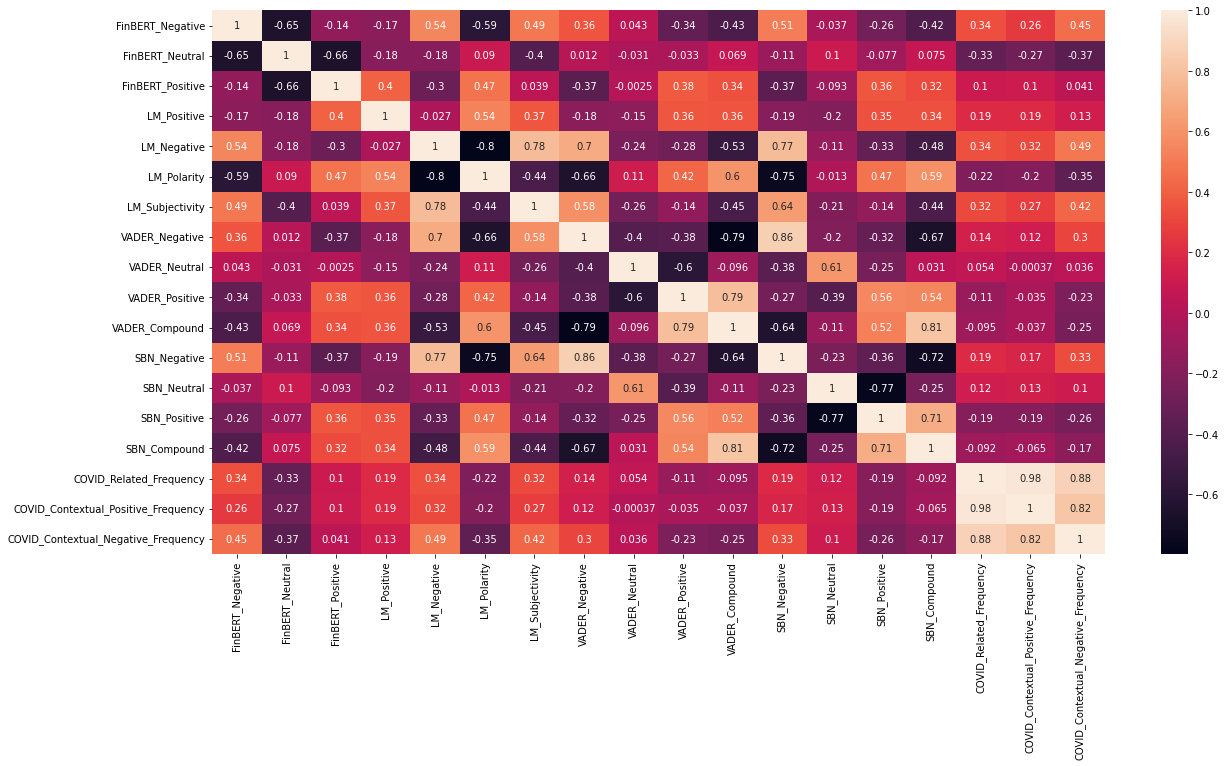

In [25]:
correlation_matrix = results_df.drop(columns="Sentence").corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True)

plt.show()


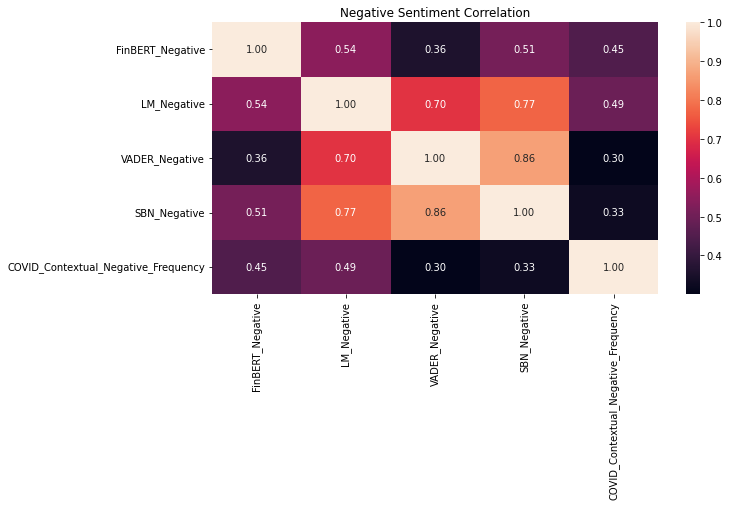

In [38]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    results_df[
        [
            "FinBERT_Negative",
            "LM_Negative",
            "VADER_Negative",
            "SBN_Negative",
            "COVID_Contextual_Negative_Frequency",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.title("Negative Sentiment Correlation")
plt.savefig("./plots/negative_sentiment_correlation.jpg", dpi=300, bbox_inches="tight")
plt.show()


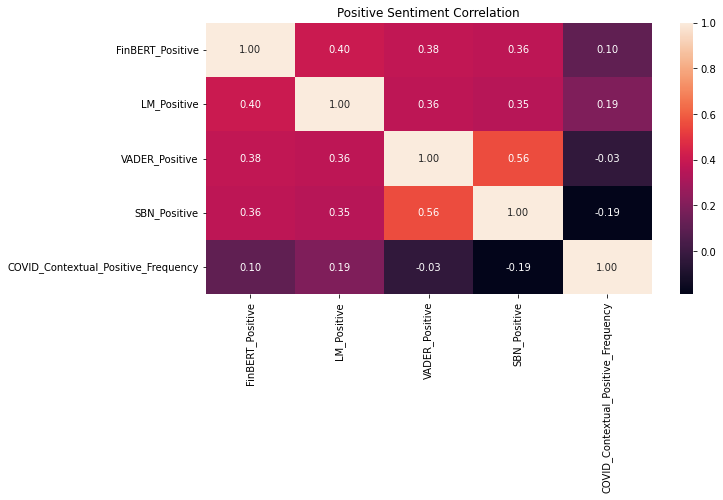

In [39]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    results_df[
        [
            "FinBERT_Positive",
            "LM_Positive",
            "VADER_Positive",
            "SBN_Positive",
            "COVID_Contextual_Positive_Frequency",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.title("Positive Sentiment Correlation")
plt.savefig("./plots/positive_sentiment_correlation.jpg", dpi=300, bbox_inches="tight")
plt.show()


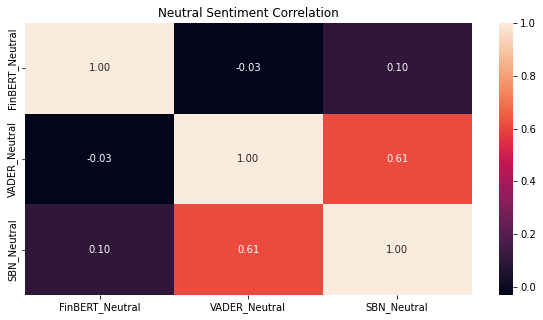

In [41]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    results_df[
        [
            "FinBERT_Neutral",
            "VADER_Neutral",
            "SBN_Neutral",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.title("Neutral Sentiment Correlation")
plt.savefig("./plots/neutral_sentiment_correlation.jpg", dpi=300, bbox_inches="tight")
plt.show()


### Comparing sentiment score


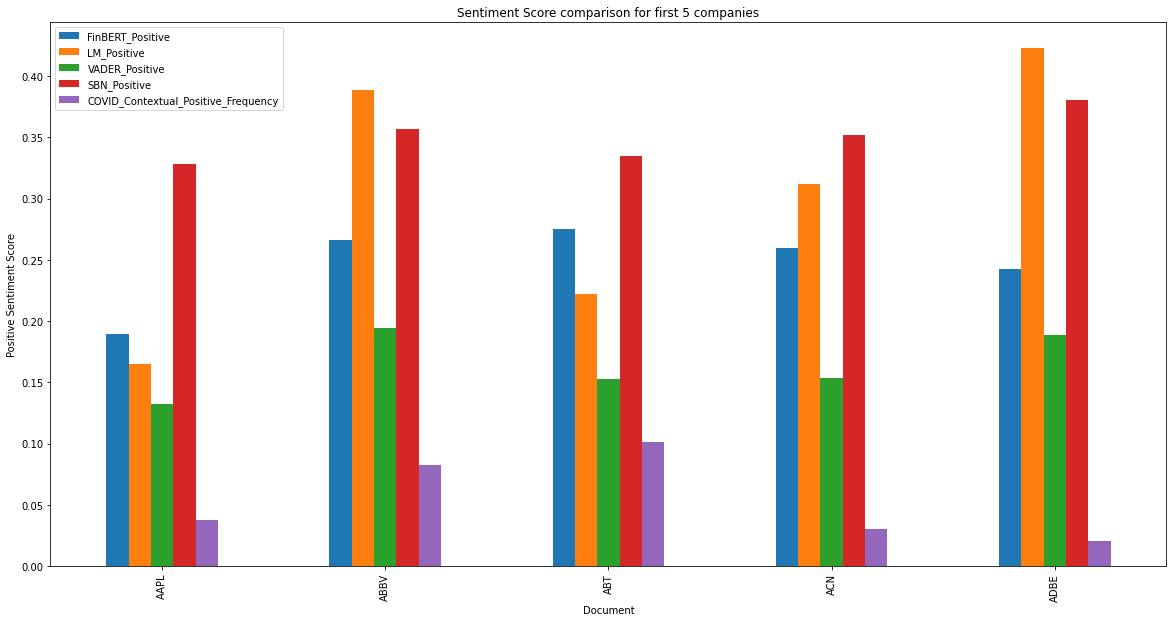

In [65]:
ax = results_df.iloc[:5].plot(
    kind="bar",
    y=["FinBERT_Positive", "LM_Positive", "VADER_Positive", "SBN_Positive", "COVID_Contextual_Positive_Frequency"],
    figsize=(20, 10),
)
ax.set_ylabel("Positive Sentiment Score")
ax.set_title("Sentiment Score comparison for first 5 companies")
plt.savefig("./plots/positive_sentiment_comparison.jpg", dpi=300, bbox_inches="tight")
plt.show()


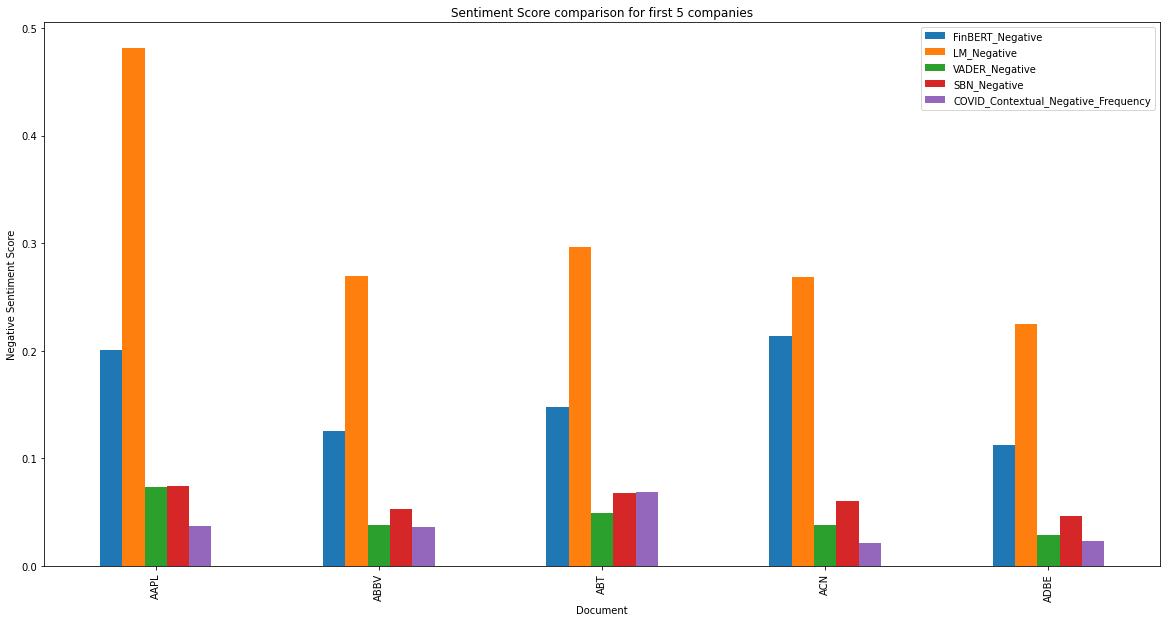

In [66]:
ax = results_df.iloc[:5].plot(
    kind="bar",
    y=[
        "FinBERT_Negative",
        "LM_Negative",
        "VADER_Negative",
        "SBN_Negative",
        "COVID_Contextual_Negative_Frequency",
    ],
    figsize=(20, 10),
)
ax.set_ylabel("Negative Sentiment Score")
ax.set_title("Sentiment Score comparison for first 5 companies")
plt.savefig("./plots/negative_sentiment_comparison.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Checking COVID-19 mentions

In [44]:
results_df.query("COVID_Related_Frequency == 0")

,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,VADER_Positive,VADER_Compound,SBN_Negative,SBN_Neutral,SBN_Positive,SBN_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence
Document,,,,,,,,,,,,,,,,,,,


All MD&A sections mention terms related to COVID-19.

## Comparing Stock Prices with Results from Sentiment Analysis


### Loading Stock Data


In [45]:
stock_df = pd.read_csv("./data/stock_prices.csv", parse_dates=["Date"])
stock_df

,Date,Close,Ticker
0,2020-06-01 00:00:00-04:00,218.529816,MSFT
1,2021-06-01 00:00:00-04:00,265.033173,MSFT
2,2020-06-01 00:00:00-04:00,126.193336,AAPL
3,2021-06-01 00:00:00-04:00,134.841141,AAPL
4,2020-06-01 00:00:00-04:00,133.304092,NVDA
...,...,...,...
195,2021-06-01 00:00:00-04:00,83.541824,MU
196,2020-06-01 00:00:00-04:00,57.171944,GILD
197,2021-06-01 00:00:00-04:00,61.500305,GILD
198,2020-06-01 00:00:00-04:00,45.996845,BX


### Loading Industry Data

In [46]:
ticker_data = pd.read_csv("./data/constituents.csv")

ticker_data["Symbol"] = ticker_data["Symbol"].str.replace(".", "-")

ticker_data = (
    ticker_data.set_index("Symbol").rename_axis("Ticker").join(results_df, how="inner")
)[["Name", "Sector"]].sort_index()

ticker_data


,Name,Sector
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology
...,...,...
UPS,United Parcel Service,Industrials
V,Visa,Information Technology
VRTX,Vertex Pharmaceuticals,Health Care
VZ,Verizon Communications,Communication Services


### Merging Datasets


In [47]:
# Calculate the yearly price change for each ticker
stock_df["Year"] = stock_df["Date"].dt.year

price_change_df = stock_df.pivot(
    index="Ticker", columns="Year", values="Close"
).pct_change(axis=1)

# Reset index and prepare for merging with the result
price_change_df = price_change_df.reset_index()
price_change_df = price_change_df.drop(columns=2020)
price_change_df.columns = ["Ticker", "Price_Change_%"]
price_change_df = price_change_df.set_index("Ticker").rename_axis("Document")

merged_df = results_df.join(price_change_df).join(ticker_data).reset_index()

merged_df

,Document,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,...,SBN_Neutral,SBN_Positive,SBN_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence,Price_Change_%,Name,Sector
0,AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,...,0.597602,0.328030,0.305426,0.045113,0.037594,0.037594,133,0.068528,Apple,Information Technology
1,ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,...,0.589874,0.357345,0.357100,0.089928,0.082734,0.035971,278,0.235676,AbbVie,Health Care
2,ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,...,0.589775,0.334491,0.269774,0.130864,0.101235,0.069136,405,0.074896,Abbott Laboratories,Health Care
3,ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,...,0.588017,0.351840,0.317782,0.060606,0.030303,0.021645,231,0.246055,Accenture,Information Technology
4,ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,...,0.573094,0.380812,0.380286,0.033557,0.020134,0.023490,298,0.140731,Adobe,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,...,0.547907,0.378458,0.349425,0.055310,0.037611,0.019912,452,0.301305,United Parcel Service,Industrials
84,V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,...,0.614880,0.307672,0.233386,0.027108,0.012048,0.006024,332,0.109635,Visa,Information Technology
85,VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,...,0.537950,0.408555,0.403438,0.096990,0.070234,0.046823,299,-0.277622,Vertex Pharmaceuticals,Health Care
86,VZ,0.170879,0.583512,0.245608,0.282577,0.341142,-0.024493,0.036912,0.046382,0.785451,...,0.545549,0.384534,0.328190,0.087848,0.067350,0.048316,683,-0.013023,Verizon Communications,Communication Services


### VADER vs. Stock Price Change

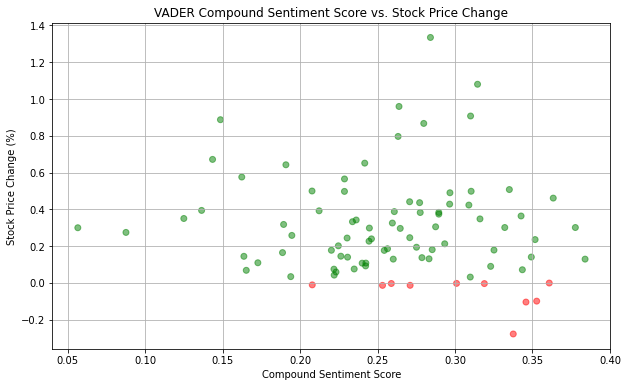

In [48]:
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["VADER_Compound"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)

plt.xlabel("Compound Sentiment Score")
plt.ylabel("Stock Price Change (%)")
plt.title("VADER Compound Sentiment Score vs. Stock Price Change")

plt.grid(True)
# plt.savefig("./plots/VADER_Compound_vs_Price_Change.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Loughran and McDonald vs. Stock Price Change

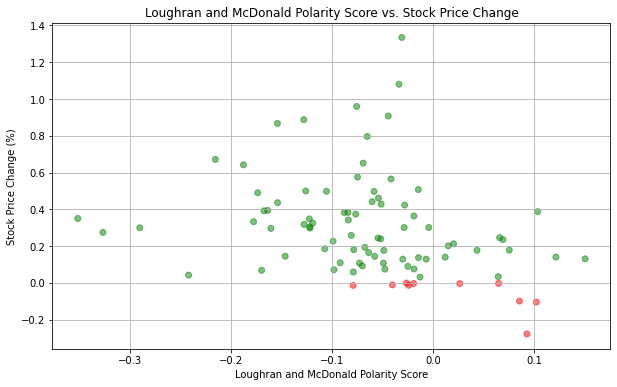

In [49]:
# create a scatter plot of the loughran and mcdonald dictionary and the price change
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["LM_Polarity"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)

plt.xlabel("Loughran and McDonald Polarity Score")
plt.ylabel("Stock Price Change (%)")
plt.title("Loughran and McDonald Polarity Score vs. Stock Price Change")

plt.grid(True)
# plt.savefig("./plots/LM_Compound_vs_Price_Change.jpg", dpi=300, bbox_inches="tight")
plt.show()

### SentiBigNomics vs. Stock Price Change


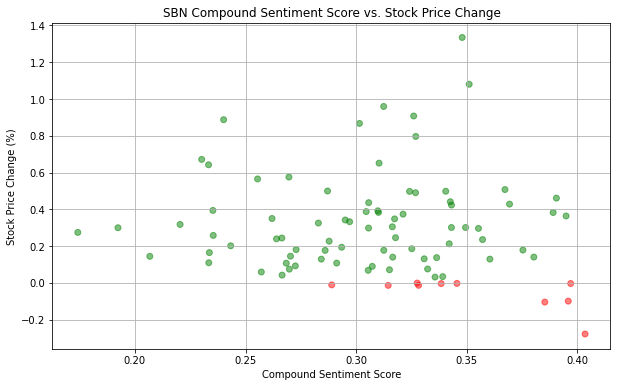

In [50]:
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["SBN_Compound"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)

plt.xlabel("Compound Sentiment Score")
plt.ylabel("Stock Price Change (%)")
plt.title("SBN Compound Sentiment Score vs. Stock Price Change")

plt.grid(True)
# plt.savefig("./plots/SBN_Compound_vs_Price_Change.jpg", dpi=300, bbox_inches="tight")
plt.show()

### FinBERT vs. Stock Price Change


Since most sentences have a neutral sentiment, we denote an overall document as "positive" if the average positive sentiment score is greater than the average negative sentiment score, and vice versa. We then calculate the stock price change for each ticker and compare it with the sentiment analysis results.

In [51]:
merged_df["FinBERT_Class"] = (
    merged_df[["FinBERT_Negative", "FinBERT_Positive"]]
    .idxmax(axis=1)
    .str.split("_")
    .str[1]
)

merged_df

,Document,FinBERT_Negative,FinBERT_Neutral,FinBERT_Positive,LM_Positive,LM_Negative,LM_Polarity,LM_Subjectivity,VADER_Negative,VADER_Neutral,...,SBN_Positive,SBN_Compound,COVID_Related_Frequency,COVID_Contextual_Positive_Frequency,COVID_Contextual_Negative_Frequency,Sentence,Price_Change_%,Name,Sector,FinBERT_Class
0,AAPL,0.200770,0.609698,0.189531,0.165414,0.481203,-0.169925,0.035307,0.073143,0.794820,...,0.328030,0.305426,0.045113,0.037594,0.037594,133,0.068528,Apple,Information Technology,Negative
1,ABBV,0.125290,0.608638,0.266072,0.388489,0.269784,0.068945,0.035459,0.038511,0.767079,...,0.357345,0.357100,0.089928,0.082734,0.035971,278,0.235676,AbbVie,Health Care,Positive
2,ABT,0.147613,0.577167,0.275220,0.222222,0.296296,-0.047901,0.030115,0.049383,0.790358,...,0.334491,0.269774,0.130864,0.101235,0.069136,405,0.074896,Abbott Laboratories,Health Care,Positive
3,ACN,0.214290,0.526049,0.259661,0.311688,0.268398,0.065656,0.038630,0.038515,0.807810,...,0.351840,0.317782,0.060606,0.030303,0.021645,231,0.246055,Accenture,Information Technology,Positive
4,ADBE,0.112824,0.644548,0.242627,0.422819,0.224832,0.121365,0.032955,0.029131,0.781819,...,0.380812,0.380286,0.033557,0.020134,0.023490,298,0.140731,Adobe,Information Technology,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,UPS,0.196942,0.507644,0.295414,0.349558,0.345133,-0.028857,0.036980,0.037546,0.753836,...,0.378458,0.349425,0.055310,0.037611,0.019912,452,0.301305,United Parcel Service,Industrials,Positive
84,V,0.179173,0.697402,0.123426,0.237952,0.412651,-0.092169,0.044104,0.067554,0.783389,...,0.307672,0.233386,0.027108,0.012048,0.006024,332,0.109635,Visa,Information Technology,Negative
85,VRTX,0.138450,0.577324,0.284225,0.401338,0.311037,0.092642,0.039203,0.037408,0.774615,...,0.408555,0.403438,0.096990,0.070234,0.046823,299,-0.277622,Vertex Pharmaceuticals,Health Care,Positive
86,VZ,0.170879,0.583512,0.245608,0.282577,0.341142,-0.024493,0.036912,0.046382,0.785451,...,0.384534,0.328190,0.087848,0.067350,0.048316,683,-0.013023,Verizon Communications,Communication Services,Positive


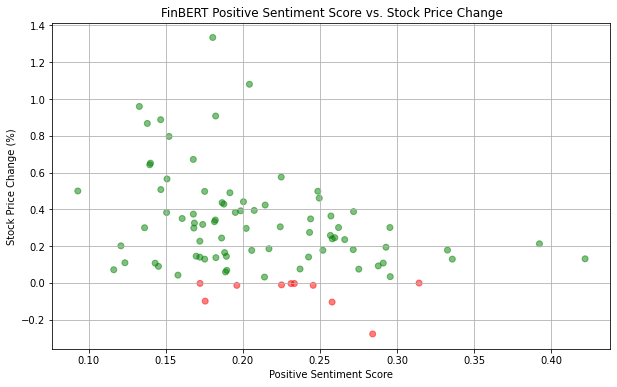

In [52]:
# plot for FinBERT both positive and negative sentiment scores
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["FinBERT_Positive"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)


plt.xlabel("Positive Sentiment Score")
plt.ylabel("Stock Price Change (%)")
plt.title("FinBERT Positive Sentiment Score vs. Stock Price Change")

plt.grid(True)
# plt.savefig("./plots/FinBERT_Positive_vs_Price_Change.jpg", dpi=300, bbox_inches="tight")
plt.show()

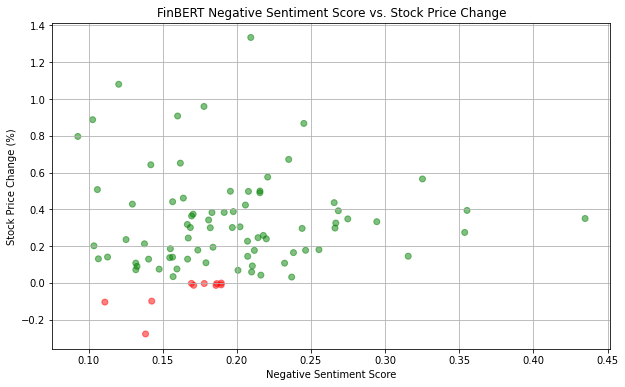

In [53]:
# plot for FinBERT both positive and negative sentiment scores
plt.figure(figsize=(10, 6))

# Create a color map based on the Price Change %
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

plt.scatter(
    merged_df["FinBERT_Negative"],
    merged_df["Price_Change_%"],
    c=colors,
    alpha=0.5,
    label=["Negative Change", "Positive Change"],
)


plt.xlabel("Negative Sentiment Score")
plt.ylabel("Stock Price Change (%)")
plt.title("FinBERT Negative Sentiment Score vs. Stock Price Change")

plt.grid(True)
# plt.savefig("./plots/FinBERT_Negative_vs_Price_Change.jpg", dpi=300, bbox_inches="tight")
plt.show()

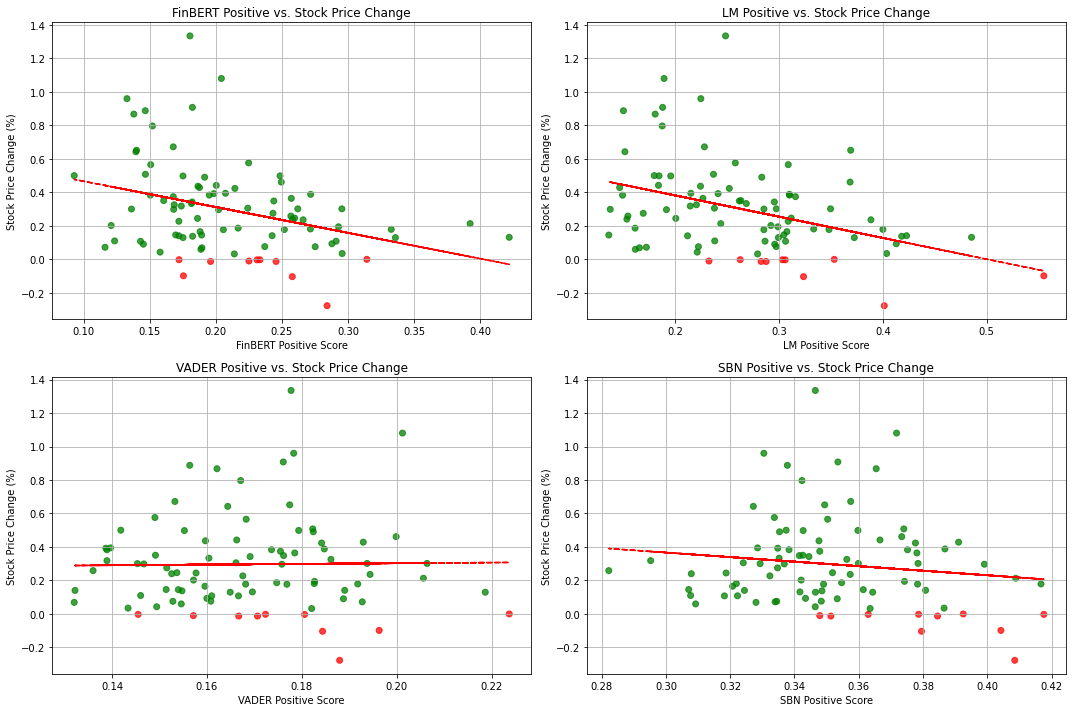

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define color map
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

# FinBERT Positive
axs[0, 0].scatter(
    merged_df["FinBERT_Positive"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[0, 0].set_title("FinBERT Positive vs. Stock Price Change")
axs[0, 0].set_xlabel("FinBERT Positive Score")
axs[0, 0].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["FinBERT_Positive"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[0, 0].plot(merged_df["FinBERT_Positive"], p(merged_df["FinBERT_Positive"]), "r--")
axs[0, 0].grid(True)

# LM Positive
axs[0, 1].scatter(
    merged_df["LM_Positive"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[0, 1].set_title("LM Positive vs. Stock Price Change")
axs[0, 1].set_xlabel("LM Positive Score")
axs[0, 1].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["LM_Positive"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[0, 1].plot(merged_df["LM_Positive"], p(merged_df["LM_Positive"]), "r--")
axs[0, 1].grid(True)

# VADER Positive
axs[1, 0].scatter(
    merged_df["VADER_Positive"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[1, 0].set_title("VADER Positive vs. Stock Price Change")
axs[1, 0].set_xlabel("VADER Positive Score")
axs[1, 0].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["VADER_Positive"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[1, 0].plot(merged_df["VADER_Positive"], p(merged_df["VADER_Positive"]), "r--")
axs[1, 0].grid(True)

# SBN Positive
axs[1, 1].scatter(
    merged_df["SBN_Positive"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[1, 1].set_title("SBN Positive vs. Stock Price Change")
axs[1, 1].set_xlabel("SBN Positive Score")
axs[1, 1].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["SBN_Positive"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[1, 1].plot(merged_df["SBN_Positive"], p(merged_df["SBN_Positive"]), "r--")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(
    "./plots/positive_sentiment_vs_price_change.jpg", dpi=300, bbox_inches="tight"
)
plt.show()


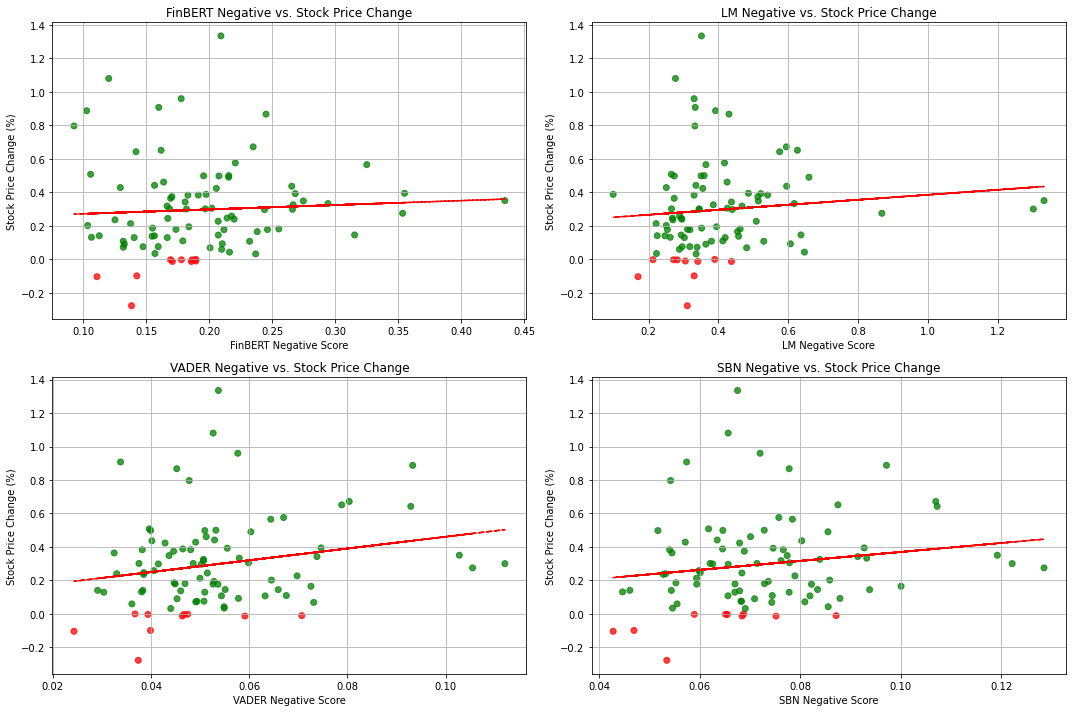

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define color map
colors = merged_df["Price_Change_%"].apply(lambda x: "red" if x < 0 else "green")

# FinBERT Negative
axs[0, 0].scatter(
    merged_df["FinBERT_Negative"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[0, 0].set_title("FinBERT Negative vs. Stock Price Change")
axs[0, 0].set_xlabel("FinBERT Negative Score")
axs[0, 0].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["FinBERT_Negative"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[0, 0].plot(merged_df["FinBERT_Negative"], p(merged_df["FinBERT_Negative"]), "r--")
axs[0, 0].grid(True)

# LM Negative
axs[0, 1].scatter(
    merged_df["LM_Negative"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[0, 1].set_title("LM Negative vs. Stock Price Change")
axs[0, 1].set_xlabel("LM Negative Score")
axs[0, 1].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["LM_Negative"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[0, 1].plot(merged_df["LM_Negative"], p(merged_df["LM_Negative"]), "r--")
axs[0, 1].grid(True)

# VADER Negative
axs[1, 0].scatter(
    merged_df["VADER_Negative"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[1, 0].set_title("VADER Negative vs. Stock Price Change")
axs[1, 0].set_xlabel("VADER Negative Score")
axs[1, 0].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["VADER_Negative"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[1, 0].plot(merged_df["VADER_Negative"], p(merged_df["VADER_Negative"]), "r--")
axs[1, 0].grid(True)

# SBN Negative
axs[1, 1].scatter(
    merged_df["SBN_Negative"], merged_df["Price_Change_%"], c=colors, alpha=0.75
)
axs[1, 1].set_title("SBN Negative vs. Stock Price Change")
axs[1, 1].set_xlabel("SBN Negative Score")
axs[1, 1].set_ylabel("Stock Price Change (%)")
# Add trend line
z = np.polyfit(merged_df["SBN_Negative"], merged_df["Price_Change_%"], 1)
p = np.poly1d(z)
axs[1, 1].plot(merged_df["SBN_Negative"], p(merged_df["SBN_Negative"]), "r--")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(
    "./plots/negative_sentiment_vs_price_change.jpg", dpi=300, bbox_inches="tight"
)
plt.show()


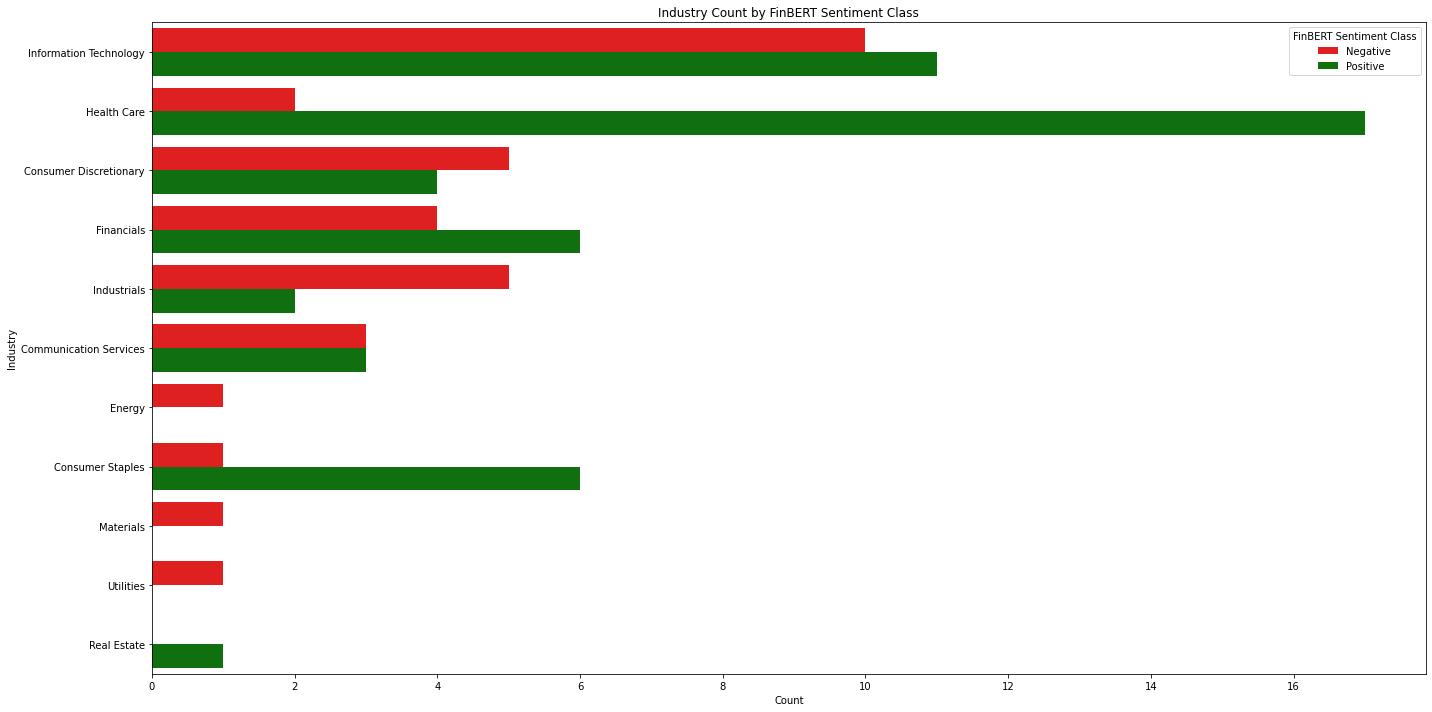

In [54]:
industry_count = (
    merged_df.groupby("FinBERT_Class")["Sector"].value_counts().to_frame().reset_index()
)

plt.figure(figsize=(20, 10))
sns.countplot(
    data=merged_df,
    y="Sector",
    hue="FinBERT_Class",
    palette={"Negative": "red", "Positive": "green"},
)

plt.title("Industry Count by FinBERT Sentiment Class")
plt.ylabel("Industry")
plt.xlabel("Count")
plt.legend(title="FinBERT Sentiment Class")

plt.tight_layout()
# plt.savefig("./plots/Industry_Count_by_FinBERT_Sentiment_Class.jpg", dpi=300, bbox_inches="tight")
plt.show()


### COVID related analysis 

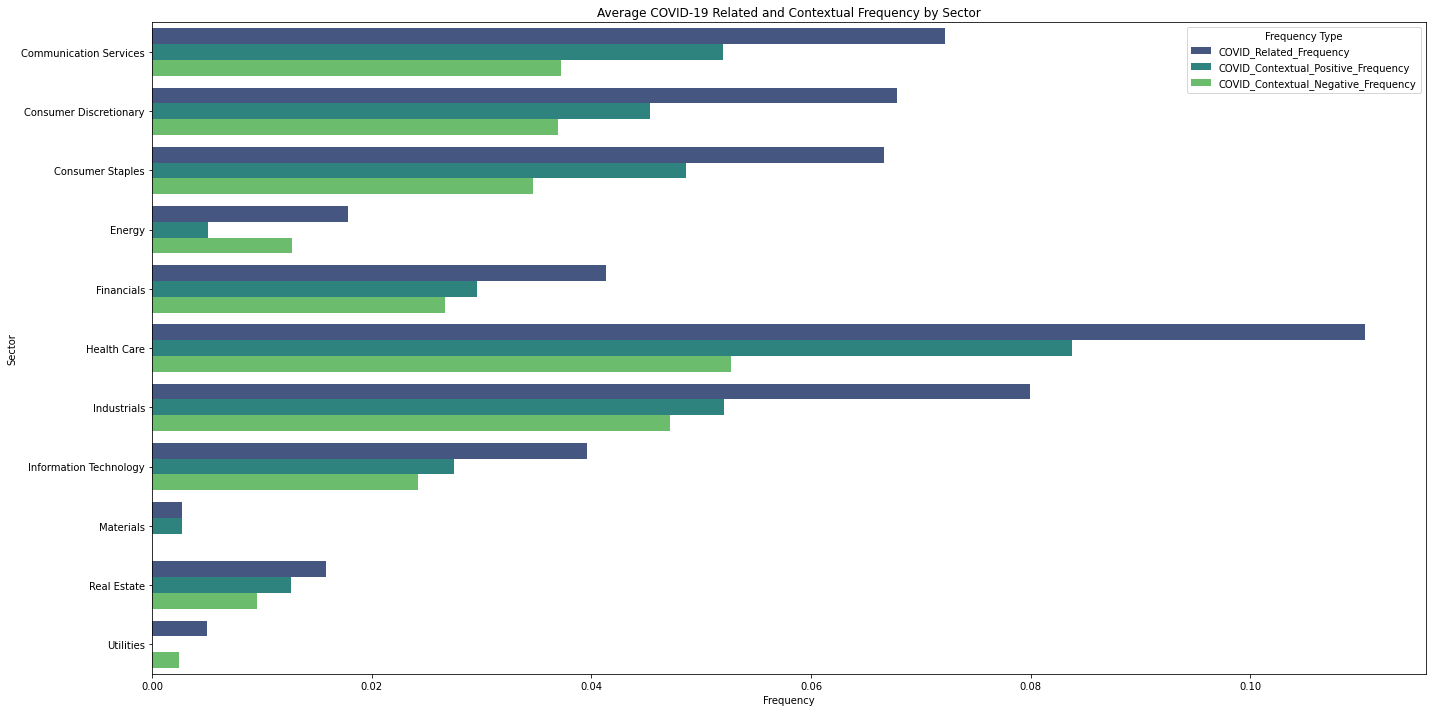

In [55]:
# create the dataset adn plot the average covid related frequency, contexual positive and negative by sector
covid_contextual_freq = (
    merged_df.groupby("Sector")[
        ["COVID_Related_Frequency", "COVID_Contextual_Positive_Frequency", "COVID_Contextual_Negative_Frequency"]
    ]
    .mean()
    .reset_index()
)

covid_contextual_freq = pd.melt(
    covid_contextual_freq,
    id_vars="Sector",
    value_vars=[
        "COVID_Related_Frequency",
        "COVID_Contextual_Positive_Frequency",
        "COVID_Contextual_Negative_Frequency",
    ],
    var_name="Frequency_Type",
    value_name="Frequency",
)

plt.figure(figsize=(20, 10))
sns.barplot(
    data=covid_contextual_freq,
    x="Frequency",
    y="Sector",
    hue="Frequency_Type",
    palette="viridis",
)

plt.title("Average COVID-19 Related and Contextual Frequency by Sector")
plt.xlabel("Frequency")
plt.ylabel("Sector")
plt.legend(title="Frequency Type")

plt.tight_layout()
# plt.savefig("./plots/Average_COVID-19_Related_and_Contextual_Frequency_by_Sector.jpg", dpi=300, bbox_inches="tight")
plt.show()
